In [1]:
import os
import sys
import gc
import random
from functools import partial

import numpy as np
import pandas as pd
import scipy
import torch

from scipy.special import j1

from PadeModels import Model, LaplacianModel
from PadeData import PadeData, PadeLaplacianData
from CustomTrainer import Trainer, TrainerLaplacian
from TBCPostProcessor import TBCPostprocessor
from FractionDecomposer import FractionDecomposer
from HyperoptSearcher import ParameterOptimizer, ParameterOptimizerLaplacian
from DiffSolver import HyperbolicalSolverImp, default_args
from SolutionAnimation import create_animation, create_3d_animation

### Physical solution 

In [2]:
def B_function(t):
    return j1(t) / t if t != 0 else 0.5

In [3]:
solver = HyperbolicalSolverImp()

In [21]:
physical_solution = solver.solve_iteration(**default_args, B_function = B_function)

5.104430604903334


### Load model

In [5]:
def target_function(x):
    value = np.sqrt(x**2 + 1) - x

    return value

In [6]:
def physical_target_function(t):
    return j1(t)/t

In [7]:
seed_value = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
num_poles = 7

In [9]:
test = ParameterOptimizer(target_function)
#test.optimize(num_poles)

In [11]:
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

optimal_config = pd.read_csv(f'FixedMesh_results/Optimal_config_for_{num_poles}_poles.csv').to_dict()
num_epochs = optimal_config.pop('num_epochs')[0]
optimal_config.pop('Metric value')
num_epochs = 101

model_args = {name : value[0] for name, value in optimal_config.items()}
model_args['input_dim'] = num_poles

train_df = PadeData(num_poles, test.train_s0, test.train_s1, test.mesh_size, target_function)
val_df = PadeData(num_poles, test.val_s0, test.val_s1, test.mesh_size, target_function)
model = Model(**model_args)
trainer_ = Trainer(model, train_df, val_df, num_epochs, verbose = 1)

In [12]:
model, resume_df = trainer_.train()

100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


### PostProcessing

In [13]:
model = model.cpu()
postprocessor = TBCPostprocessor(model)

In [14]:
p_coefs, q_coefs = postprocessor._collect_kernel_image()

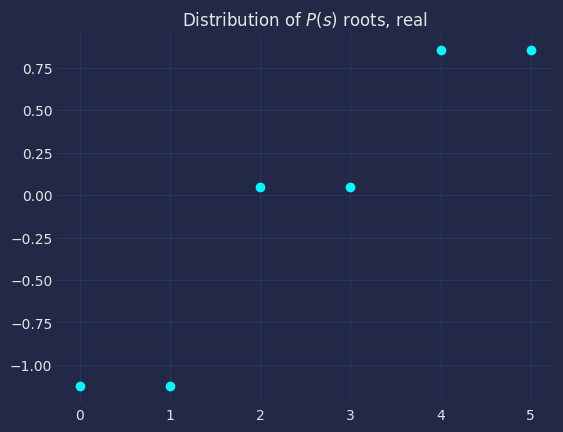

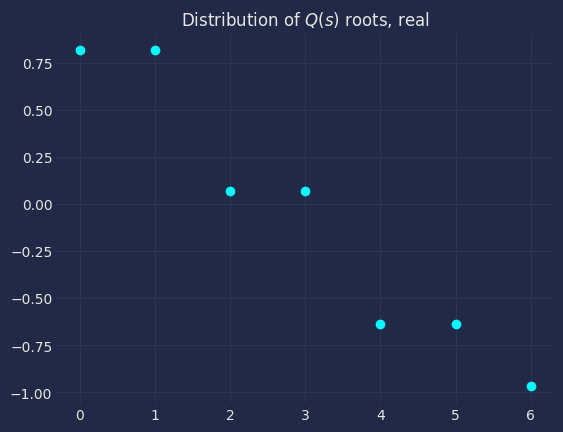

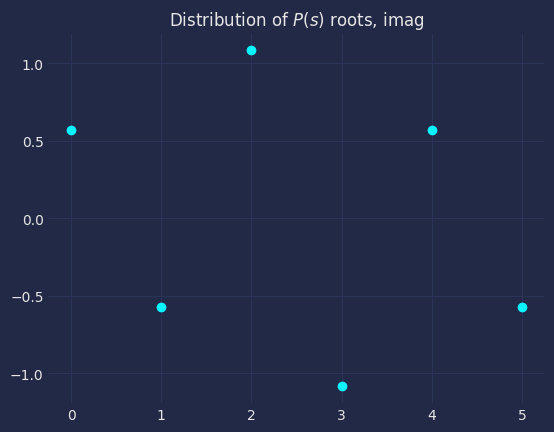

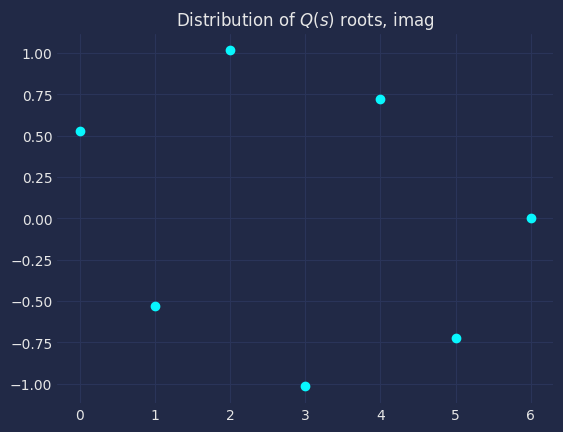

In [15]:
postprocessor._plot_poles()

In [16]:
duplets = postprocessor._frouassar_duplets()

In [17]:
duplets

array([], dtype=float64)

### Optimal config for hidden_size, num_hidden_layers, num_epochs

In [16]:
#Построить hist по распределениям для параметров

### Collect metrics (C[a, b], MAPE, C[a; b] in original space)

In [17]:
#Построить таблички по параметрам

### Physical Task Solution

In [18]:
decomposer = FractionDecomposer()
postprocessor = TBCPostprocessor(model.cpu())
p, q = postprocessor._collect_kernel_image()
decomposer.check_convergence(p_coefs, q_coefs, solver.time)

3.4416913763379853e-15

In [19]:
def kernel(p, q, t):
    return decomposer.collect_exponential_stats(p, q, t).real

In [20]:
B_function_model = partial(kernel, p, q)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

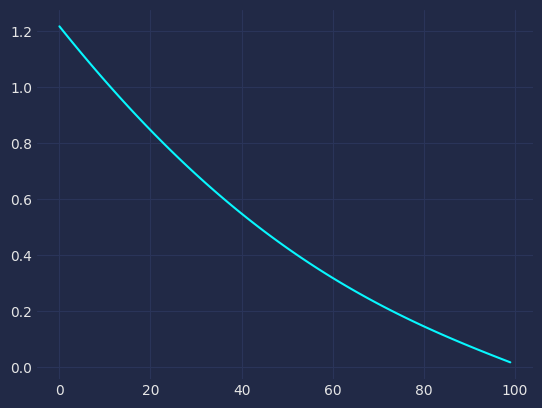

In [35]:
import matplotlib.pyplot as plt
plt.plot(B_function_model(np.linspace(0.1, 2, 100)))
plt.plot(B_function(np.linspace(0.1, 2, 100)))

In [38]:
B_function(np.linspace(0.1, 2, 100))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
model_solution = solver.solve_iteration(**default_args, B_function = B_function_model)

5.104430604903334


In [23]:
x = model_solution - physical_solution

In [27]:
e = x.mean(axis = 0).mean(axis = 0).mean(axis = 0)

In [28]:
max(abs(e))

2.22878240706464e+131

In [26]:
max(abs(e))

4.930706734021475e+127

In [59]:
for i in range(100):
    k = np.max(np.abs(physical_solution[i, :, :, :] - model_solution[i, :, :, :]))
    if k !=0:
        print(i)
        break

46


In [43]:
solver.time[]

array([-0.99, -0.97, -0.95, -0.93, -0.91, -0.89, -0.87, -0.85, -0.83,
       -0.81, -0.79, -0.77, -0.75, -0.73, -0.71, -0.69, -0.67, -0.65,
       -0.63, -0.61, -0.59, -0.57, -0.55, -0.53, -0.51, -0.49, -0.47,
       -0.45, -0.43, -0.41, -0.39, -0.37, -0.35, -0.33, -0.31, -0.29,
       -0.27, -0.25, -0.23, -0.21, -0.19, -0.17, -0.15, -0.13, -0.11,
       -0.09, -0.07, -0.05, -0.03, -0.01,  0.01,  0.03,  0.05,  0.07,
        0.09,  0.11,  0.13,  0.15,  0.17,  0.19,  0.21,  0.23,  0.25,
        0.27,  0.29,  0.31,  0.33,  0.35,  0.37,  0.39,  0.41,  0.43,
        0.45,  0.47,  0.49,  0.51,  0.53,  0.55,  0.57,  0.59,  0.61,
        0.63,  0.65,  0.67,  0.69,  0.71,  0.73,  0.75,  0.77,  0.79,
        0.81,  0.83,  0.85,  0.87,  0.89,  0.91,  0.93,  0.95,  0.97,
        0.99])

In [36]:
np.where(np.abs(physical_solution - model_solution) == 1.9450390713855224e+135)

(array([99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 

Анимация сохранена как Model_solution.gif


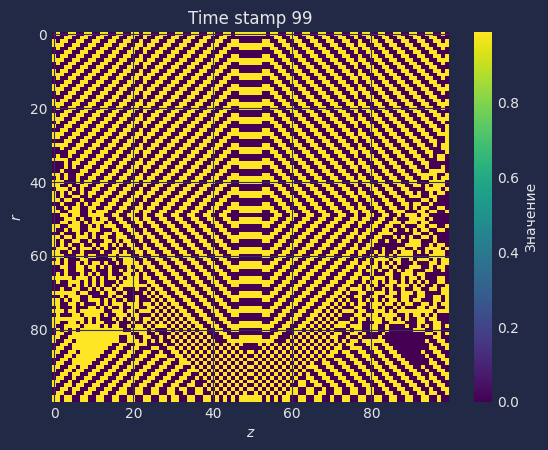

In [25]:
create_animation(model_solution[:, :, 10, :], solver.z, solver.r, 'Model_solution.gif')

In [26]:
np.where(np.max(np.abs(model_solution - physical_solution))==1.9450390713855224e+135)

(array([0]),)

In [34]:
model_solution.min()

-9.278310893684387e+206

### Divergence between model and original solution, 